# <a id="outlines">Outlines:
## <a href="#libraries"><b>1. Libraries
## <a href="#arguments"><b>2. Global Arguments
## <a href="#helper_functions"><b>3. Helper Functions
## <a href="#classes"><b>4. Classes:
### - <a href="#class_data_analysis"><b>Class Data_Analysis()
### - <a href="#class_x_data_treatment"><b>Class X_Data_Treatment()
### - <a href="#class_dataset"><b>Class Dataset()
### - <a href="#class_trainlgbclassifier"><b>Class TrainLGBClassifier()
### - <a href="#class_fs_ir"><b>Class IterativeReduction()
### - <a href="#class_fs_boruta"><b>Class Boruta()
## <a href="#prepare_data"><b>5. Prepare Data    
## <a href="#feature_selection"><b>6. Feature Selection
### - <a href="#run_iterative_reduction"><b>6.1 Iterative Reduction Approach
### - <a href="#run_boruta"><b>6.2 Boruta Approach
### - <a href="#model_performance"><b>6.3 Model Performance

<a id="libraries"></a>
<b><h1>1. Libraries</h1>
<a href="#outlines"><b>Up to outlines</b>

In [1]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import joblib

# Operating System
import os
from datetime import datetime
import warnings
import pickle
from argparse import Namespace

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Mathematics and Statistics
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import loguniform

# NLP related 
import string
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

<a id="arguments"></a>
<b><h1>2. Global Arguments</h1>
<a href="#outlines"><b>Up to outlines</b>

In [2]:
args = Namespace(
    ##### File names and path names
    input_file_name     = '/kaggle/input/imdb-data/IMDb_dataset.csv',
    output_path         = '/kaggle/working/',
    model_data_name     = '/kaggle/input/imdb-data/Modeling_Data.csv',
    IR_results_filename = '/kaggle/input/imdb-outputs/IR_results.pkl',
    Boruta_results_filename = '/kaggle/input/imdb-outputs/Boruta_results.pkl',
    
    ##### Features
    target_feature     = 'sentiment_number',
    
    ##### For generating TFIDF features
    feature_tfidf      = 'movie_review',
    feature_tfidf_abbr = 'rv',
    max_features       = 2000,
    min_df             = 0.01,
    
    ##### Data Treatment
    missing_th         = 0.5,
    
    ##### Training
    test_size          = 0.3,
    partition_seed     = 42,
    metric             = ['logloss','auc'],
    params_LGB         = {'boosting_type'    : 'gbdt',
                          'objective'        : 'binary',
                          'colsample_bytree' : 0.2,
                          'learning_rate'    : 0.05,
                          'min_child_samples': 10,
                          'min_child_weight' : 5,
                          'max_depth'        : -1,
                          'min_split_gain'   : 0,
                          'num_leaves'       : 31,
                          'subsample_for_bin': 50000,
                          'subsample_freq'   : 1,
                          'n_estimators'     : 5000}
    )

<a id="helper_functions"></a>
<b><h1>3. Helper Functions</h1>
<a href="#outlines"><b>Up to outlines</b>

In [3]:
def print_description(text,n=100):
    """
    This function prints a description.
    Attribute: 
            text (str) - a text to print
    """
    print(text)
    print('-'*n)
    

In [4]:
def test_nonrepeating_ascending_list(_list,_min,_max):
    """
    This function is used in Boruta feature selection. 
    It tests whether the integers in _list are non-repeating, 
    sorted in ascending order, and within the range of [a, b].
    
    Attribute: 
            _list (a list of integer) - the list of interest
            _min (integer) - lower bound
            _max (integer) - upper bound
    
    Return:
            True / False
    """
    if len(_list) != len(set(_list)):
        print('List elements are repeating')
        return False
    
    _list_sorted = sorted(_list)
    if _list_sorted != _list:
        print('List elements are not ascending')
        return False
    
    if max(_list)>_max or min(_list)<_min:
        print('Some elements are out of valid range')
        return False
    
    return True

<a id="classes"></a>
<b><h1>4. Classes</h1>
<a href="#outlines"><b>Up to outlines</b>

<a id="class_data_analysis"></a>
<h2>Class Data_Analysis()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [5]:
class Data_Analysis():
    """
    This class is used to conduct data analysis for a given dataset.
    """
    
    def __init__(self):
        self.data_of_interest       = None
        self.descriptive_statistics = None
        print_description("Data_Analysis object is created")
    
    @staticmethod
    def get_missing_values(data):
        """
        This function gets missing value information.
        Attribute: 
            data (DataFrame) - the data of interest
        Return: 
            (DataFrame) - inforamtion about missing value for all columns
        """
        missing_info = data.apply(lambda x:x.isna().sum()).reset_index()
        missing_info.columns = ['feature','n_miss']
        missing_info['n_non_missing'] = data.apply(lambda x:x.count()).values
        missing_info['n'] = missing_info['n_non_missing'] + missing_info['n_miss']
        missing_info['p_miss'] = missing_info['n_miss'] / missing_info['n']
        return missing_info
    
    def get_descriptive_statistics(self, data):
        """
        This function gets missing value information.
        Attribute: 
            data (DataFrame) - the data of interest
        Return: 
            self.descriptive_statistics - updated 
        """
        self.data_of_interest = data
        ds_df = self.get_missing_values(data)
        ds_df['Type']     = data.dtypes.values
        ds_df['N_unique'] = data.nunique().values
        ds_df['Mean']     = data.apply(lambda x: x.mean() if x.dtype!='O' else pd.NA).values
        
        sample = data.sample(n=5,replace=True)
        for i in range(data.shape[1]):
            feature = data.columns[i]
            ds_df.loc[i,'sample'] = ','.join(sample[feature].astype(str))
        
        self.descriptive_statistics = ds_df
        print_description("Descriptive statistics are created")

<a id="class_x_data_treatment"></a>
<h2>Class X_Data_Treatment()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [6]:
class X_Data_Treatment():
    """
    This class is used to conduct data manipulation in the X_Data.
        - missing data imputation
        - create TFIDF features based on a given text feature in X_Data
    """
    
    def __init__(self, data_original):
        self.data_original  = data_original
        self.run_imputation = False 
        self.data_imputed   = data_original
        self.run_tfidf      = False
        self.data_tfidf     = None
        print_description("Data_Treatment object is created")
    
    def fill_na(self, strategy):
        """
        This function conducts missing value imputation.
        Attribute: 
            strategy (str) - a given strategy: 'mode','mean','median','none'
        Return: 
            self.imputation - updated
            self.data_imputed - updated
        """
        data_to_fillna = self.data_original
        
        if strategy == 'mode':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.mode()[0]))
        elif strategy == 'mean':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.mean()))
        elif strategy == 'median':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.median()))
        elif strategy == 'none':
            data_filled = data_to_fillna
            if data_to_fillna.isna().sum().any():
                print_description("Warning - missing value detected, but not imputed")
        else:
            print_description("Error - imputation strategy is not correctly specified")

        self.imputation      = True
        self.data_imputed    = data_filled
    
    def create_tfidf_features(self, feature, feature_abbr, args):
        """
        This function creates TFIDF features with a given feature. 
        Attribute:
            feature (str) - the name for feature used for TFIDF process
            feature_abbr (str) - an abbreviation for feature that will be 
                                  used in TFIDF feature names
            args - global arguments    
        Return: 
            self.data_tfidf - updated
        """
        def lower_string(string):
            return string.lower()
        
        def remove_special_strips(text,term):
            return text.replace(term, "")
        
        def text_treatment(text):
            text = lower_string(text)
            text = remove_special_strips(text,'<br />')
            stop_punc = set(stopwords.words('english') + list(string.punctuation))
            tokenizer = ToktokTokenizer()
            filtered_tokens = [i for i in tokenizer.tokenize(text) if i not in stop_punc]
            filtered_tokens = [i.replace('.', "") for i in filtered_tokens]
            filtered_text   = ' '.join(filtered_tokens) 
            return(filtered_text)
        
        def stemmer(text):
            sinlge_stemmer = PorterStemmer()
            words = text.split()
            words_stem = [sinlge_stemmer.stem(i) for i in words]
            text_stem  = ' '.join(words_stem)
            return text_stem
        
        def create_features(max_features, min_df, corpus, feature_abbr):
            Vectorizer = TfidfVectorizer(max_features=max_features,min_df=min_df)
            result     = Vectorizer.fit_transform(corpus)
            tfidf_df   = pd.DataFrame(result.toarray(),columns=Vectorizer.get_feature_names_out())
            tfidf_df.columns = feature_abbr + '_' + tfidf_df.columns
            return(tfidf_df)
        
        text_data = self.data_imputed
        if text_data[feature].dtype == 'O':
            text_data[feature] = text_data[feature].apply(text_treatment)
            text_data[feature] = text_data[feature].apply(stemmer)
            corpus = list(text_data[feature])
            tfidf_df = create_features(max_features = args.max_features,
                                       min_df       = args.min_df,
                                       corpus       = corpus,
                                       feature_abbr = feature_abbr
                                      )
            self.data_tfidf = tfidf_df
        else:
            print_description("Error - {} in is not a text feature".format(feature))

<a id="class_dataset"></a>
<h2>Class Dataset()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [7]:
class Dataset():
    """
    This class is used to create the modeling dataset. 
    It also instantiates class Data_Analysis() and class X_Data_Treatment().
    """
    
    def __init__(self):
        self.data_raw     = None
        self.data_imputed = None
        self.data_tfidf   = None
        self.X_Data       = None
        self.X_Data_copy  = None
        self.Y_Data       = None
        self.Y_Data_copy  = None
        self.YX_Data      = None

        self.data_analysis    = Data_Analysis()
        self.x_data_treatment = None
        
        self.tfidf_features     = None
        self.add_tfidf_features = False
        
        print_description("Dataset object is created")
    
    def load_modeling_data_from_csv(self,args):
        """
        This function loads modeling data from a saved csv file.
        Attribute: 
            args - global arguments
        Return: 
            self.X_Data - updated
            self.Y_Data - updated
        """
        modeling_data = pd.read_csv(args.model_data_name)
        self.X_Data   = modeling_data.drop(args.target_feature,axis=1)
        self.Y_Data   = modeling_data[args.target_feature]
        print_description("Loaded modeling data from csv")        
        
    def add_raw_data_from_df(self, df):
        """
        This function loads a raw data from a DataFrame.
        Attribute: 
            df (DataFrame) - the DataFrame file for the raw data
        Return: 
            self.data_raw - updated
        """
        self.data_raw = df
        print_description("Loaded the raw data from df")
    
    def add_raw_data_from_csv(self, args):
        """
        This function loads a raw data from a csv file.
        Attribute: 
            args - global arguments
        Return: 
            self.data_raw - updated
        """
        self.data_raw = pd.read_csv(args.input_file_name)
        print_description("Loaded the raw data from csv") 

    def get_x_y_data(self, args, verbose=1):
        """
        This function creates X_Data(explanatory features) and Y_Data(target 
        feature) from the raw data. Remove features with high missing rate \
        (>args.missing_th).
        Attribute: 
            args - global arguments
            verbose - if 1, print the dimension of X_Data and Y_Data. 
        Return: 
            self.X_Data           - updated
            self.X_Data_copy      - updated
            self.Y_Data           - updated
            self.Y_Data_copy      - updated
            self.YX_Data          - updated
            self.x_data_treatment - updated
        """
        if self.data_raw is None:
            print_description("Error - raw data is not defined") 
        else: 
            target = args.target_feature
            Y_Data = self.data_raw[args.target_feature]
            X_Data = self.data_raw.drop([args.target_feature], axis=1)
            
            missing_info = X_Data.apply(lambda x:x.isna().sum()).reset_index()
            missing_info.columns = ['feature','n_miss']
            missing_info['n_non_missing'] = X_Data.apply(lambda x:x.count()).values
            missing_info['n'] = missing_info['n_non_missing'] + missing_info['n_miss']
            missing_info['p_miss'] = missing_info['n_miss'] / missing_info['n']
            
            features_keep = missing_info.loc[(missing_info['p_miss']<=args.missing_th),
                                             'feature']
            X_Data = X_Data[features_keep]
            
            self.X_Data      = X_Data
            self.X_Data_copy = X_Data
            self.Y_Data      = Y_Data
            self.Y_Data_copy = Y_Data
            self.YX_Data     = pd.concat([Y_Data, X_Data], axis=1)
            self.x_data_treatment = X_Data_Treatment(self.X_Data)
            
            if verbose==1:
                print("Columns with missing percentage > {} are removed".\
                      format(args.missing_th))
                print("Shape of X_Data: {}".format(X_Data.shape))
                print("Shape of Y_Data: {}".format(Y_Data.shape))
                
            print_description("X_Data, Y_Data are created") 
    
    def restore_X_Data(self):
        """
        This function restores X_Data
        Attribute: None. 
        Return: 
            self.X_Data - updated
        """
        if self.X_Data_copy is None:
            print_description("Error - No copy is available") 
        else:
            self.X_Data = self.X_Data_copy
            print_description("Restored X_Data") 
    
    def drop_feautre_from_X(self, features_to_drop):
        """
        This function removes a list of features from X_Data
        Attribute:
            features_to_drop (a list of string): the features to drop
        Return: 
            self.X_Data - updated
        """
        if self.X_Data is None: 
            print_description("Error - X_Data is not defined") 
        else:
            not_in_X = [elem for elem in features_to_drop 
                        if elem not in self.X_Data.columns] 
            if len(not_in_X)>0:
                _str = ' '.join(not_in_X)
                print_description("Error - feature(s) not in X_Data: {}".format(_str))
            else:
                df = self.X_Data,copy()
                df = df.drop(features_to_drop, axis = 1)
                self.X_Data = df
                _str = ' '.join(features_to_drop)
                print_description("Feature(s) below are dropped: {}".format(_str))

    def _fill_na(self, strategy):
        """
        This function applies the function x_data_treatment.fill_na()
        Attribute: 
            strategy (str) - 'mode', 'mean', 'median', 'none' 
        Return: 
            self.data_imputed - updated
        """
        if self.X_Data is None:
            print_description("Error - original data is not defined") 
        else: 
            self.x_data_treatment.fill_na(strategy)
            self.data_imputed   = self.x_data_treatment.data_imputed
            print_description("Missing data imputation is conducted, \
                               strategy: {}".format(strategy)) 
    
    def _create_tfidf_features(self, args):
        """
        This function applies the function \
        x_data_treatment.create_tfidf_features()
        Attribute: 
            args - global arguments
        Return: 
            self.tfidf_features - updated
            self.data_tfidf - updated
        """
        self.x_data_treatment.create_tfidf_features(args.feature_tfidf,
                                                    args.feature_tfidf_abbr,
                                                    args)
        tfidf_df = self.x_data_treatment.data_tfidf
        self.tfidf_features = list(tfidf_df.columns)
        self.data_tfidf     = tfidf_df
        print_description("TFIDF features for {} are created".\
                          format(args.feature_tfidf)) 
    
    def adding_tfidf_features(self):
        """
        This function adds self.data_tfidf to self.X_Data and \
        drops args.feature_tfidf
        Attribute: None
        Return: 
            self.X_Data - updated
            self.add_tfidf_features - updated
        """
        if self.X_Data is None:
            print_description("Error - X_data is not defined") 
        else:
            if self.data_tfidf is None:
                print_description("Error - TFIDF features are not defined") 
            else:
                x_df     = self.X_Data.copy()
                tfidf_df = self.data_tfidf.copy()
                _df      = pd.concat([x_df, tfidf_df], axis=1)
                _df      = _df.drop(args.feature_tfidf, axis=1)
                self.X_Data = _df
                self.add_tfidf_features = True
                print_description("Added TFIDF features to X_Data")

    def _get_descriptive_statistics(self, data_of_interest):
        """
        This function applies the function data_analysis.\
        get_descriptive_statistics()
        Attribute: 
            data_of_interest (DataFrame) - the data if interest
        Return: 
            self.data_analysis.descriptive_statistics - updated
        """
        self.data_analysis.get_descriptive_statistics(data_of_interest)
 
    def save_modeling_data(self):
        """
        This function saves the modeling data (Y_Data, X_Data) in a csv file
        Attribute: None
        Return: 
            Modeling_Data.csv
        """
        modeling_data = pd.concat([self.Y_Data, self.X_Data], axis=1)
        modeling_data.to_csv('Modeling_Data.csv', index=False)
        print_description("Exported Modeling Data")

<a id="class_trainlgbclassifier"></a>
<h2>Class TrainLGBClassifier()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [8]:
class TrainLGBClassifier():
    """
    This class trains a LGB model with given data and settings.
    """
    
    def __init__(self, x_input, 
                 y_input, 
                 hyperparameters, 
                 importance_type,
                 args, 
                 verbose):
        self.X_all = x_input
        self.Y_all = y_input
        self.hp    = hyperparameters
        self.model = lgb.LGBMClassifier(**hyperparameters, 
                                        importance_type=importance_type,
                                        verbose = verbose)
        self.best_score     = None
        self.best_iteration = None
        self.importance     = None
        self.performance    = pd.DataFrame(columns = ['DataPartition',
                                                      'AUC',
                                                      'AUPRC',
                                                      'Logloss'])
        
    def split_data(self, args, verbose = 0):
        """
        This function splits the data into train and validation sets.
        Attribute: 
            args - global arguments
        Return: 
            self.x1 - updated
            self.x2 - updated
            self.y1 - updated
            self.y2 - updated
        """
        X_Data = self.X_all
        Y_Data = self.Y_all
        x1,x2,y1,y2 = train_test_split(X_Data,
                                       Y_Data,
                                       test_size    = args.test_size,
                                       random_state = args.partition_seed)
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        if verbose >0:
            print_description("x1, x2, y1, y2 are created")

    def train_classifier(self, args):
        """
        This function trains the model.
        Attribute: 
            args - global arguments
        Return: 
            self.model - fitted and updated
            self.best_score - updated
            self.best_iteration - updated
            self.importance - updated
        """
        self.model.fit(X = self.x1, y = self.y1,
                       eval_metric=args.metric, 
                       eval_set=[(self.x1,self.y1),(self.x2,self.y2)],
                       callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        self.best_score = self.model.best_score_
        self.best_iteration = self.model.best_iteration_
        importance_df = pd.DataFrame(list(self.x1))
        importance_df.columns = ['feature']
        importance_df['importance'] = self.model.feature_importances_
        importance_df = importance_df.sort_values(['importance'], ascending = False)
        importance_df['rank'] = importance_df['importance'].rank(method='min',
                                                                 ascending = False)
        self.importance = importance_df
        print_description("Training is done")
    
    def save_model(self, args, name=None):
        """
        This function saves the model to a pkl file.
        Attribute: 
            args - global arguments
            name (str) - model name (suffix '.pkl' not included)
        Return: 
            model.pkl or name.pkl
        """
        path_name = args.output_path
        if name is None:
            model_name = 'model.pkl'
        else:
            model_name = name + '.pkl'
        joblib.dump(self.model, path_name + model_name)
        print_description("Model Saved")
    
    def save_importance(self, args, name=None):
        """
        This function saves feature importance to a csv file.
        Attribute: 
            args - global arguments
            name (str) - filename (suffix '.csv' not included)
        Return: 
            model_importance.csv or name.csv
        """
        path_name = args.output_path
        if name is None:
            model_name = 'model_importance.csv'
        else:
            model_name = name + '.csv'
        self.importance.to_csv(path_name + model_name, index=False)
        print_description("Feature Importance Saved")
    
    def in_sample_performance(self):
        """
        This function calculate the in-sample performance of self.model.
        Attribute: None
        Return: 
            self.performance - updated 
        """
        def calc_auc(y_pred, y_true):
            return roc_auc_score(y_true, y_pred)
        
        def calc_auprc(y_pred, y_true):
            return average_precision_score(y_true, y_pred)
        
        def calc_logloss(y_pred, y_true):
            return log_loss(y_true, y_pred)
        
        y_pred = self.model.predict_proba(self.x2)[:,1]
        y_true = self.y2
        is_auc     = calc_auc(y_pred, y_true)
        is_auprc   = calc_auprc(y_pred, y_true)
        is_logloss = calc_logloss(y_pred, y_true)
    
        perf_df = pd.DataFrame(columns = self.performance.columns)
        perf_df.loc[0,:] = ['validation', is_auc, is_auprc, is_logloss]
        self.performance = pd.concat([self.performance, perf_df], axis=0, ignore_index=True)


<a id="class_fs_ir"></a>
<h2>Class IterativeReduction()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [9]:
class IterativeReduction():
    """
    This class conducts a iterative reduction feature selection. 
    """
    
    def __init__(self, 
                 x_input, 
                 y_input, 
                 n_feature_list,
                 hyperparameters, 
                 importance_type,
                 args):
        self.x_input = x_input
        self.y_input = y_input
        self.hp      = hyperparameters
        self.importance_type = importance_type
        self.n_feature_list  = n_feature_list
        self.ir_results      = {}
        
    def iterative_reduction(self, start_n, end_n):
        """
        This function executes one iteration in an iterative reduction.
        Attribute: 
            - start_n (integer): the number of feature to reduct from
            - end_n (integer): the number of feature to reduct to
        Return: 
            self.ir_results - updated
        """
        print('Feature reduction from %d to %d ...' %(start_n,end_n))
        importance_old = self.ir_results['FL_'+str(start_n)]['importances']
        selected_features = importance_old.head(end_n)['feature'].values.tolist()
        shuffled_features = selected_features.copy()
        random.shuffle(shuffled_features)
        x_input_now = self.x_input[shuffled_features]

        LGBModel = TrainLGBClassifier(x_input = x_input_now, 
                                      y_input = self.y_input,
                                      hyperparameters = self.hp, 
                                      importance_type = self.importance_type,
                                      args    = args,
                                      verbose = 0)
        LGBModel.split_data(args)
        LGBModel.train_classifier(args)

        n_now  = x_input_now.shape[1]
        FL_now = 'FL_'+str(n_now)
        self.ir_results[FL_now] = {}
        self.ir_results[FL_now]['importances'] = LGBModel.importance
        self.ir_results[FL_now]['features']    = LGBModel.importance['feature'] 
    
    def Run_IR(self):
        """
        This function executes the complete iterative reduction procedure.
        Attribute: None
        Return: 
            self.ir_results - updated
        """
        
        ##### Initialize the Iterative Reduction
        LGBModel = TrainLGBClassifier(x_input = self.x_input, 
                                      y_input = self.y_input,
                                      hyperparameters = self.hp, 
                                      importance_type = self.importance_type,
                                      args    = args,
                                      verbose = 0)
        LGBModel.split_data(args)
        LGBModel.train_classifier(args)
        n_now  = self.x_input.shape[1]
        FL_now = 'FL_'+str(n_now)
        self.ir_results[FL_now] = {}
        self.ir_results[FL_now]['importances'] = LGBModel.importance
        self.ir_results[FL_now]['features']    = LGBModel.importance['feature']
        
        ##### Conduct the following iterations 
        for a in range(len(self.n_feature_list)-1):
            self.iterative_reduction(self.n_feature_list[a], self.n_feature_list[a+1])
    
    def save_IR_results(self):
        """
        This function saves the iterative reduction results in a pkl file.
        Attribute: None
        Return: 
            IR_results.pkl
        """
        with open('IR_results.pkl', 'wb') as f:
            pickle.dump(self.ir_results, f)
        print_description("IR_results saved")
    
    def load_IR_results(self, args):
        """
        This function loads the iterative reduction results from a pkl file.
        Attribute: None
        Return: 
            self.ir_results - updated
        """
        with open(args.IR_results_filename, 'rb') as f:
            self.ir_results = pickle.load(f)
        print_description("IR_results loaded")

<a id="class_fs_boruta"></a>
<h2>Class Boruta()</h2>
<a href="#outlines"><b>Up to outlines</b>

In [10]:
class Boruta():
    """
    This class conducts a Boruta feature selection. 
    """
    
    def __init__(self, 
                 x_input, 
                 y_input, 
                 n_iterations,
                 hyperparameters, 
                 importance_type,
                 args):
        self.x_input         = x_input
        self.y_input         = y_input
        self.n_iterations    = n_iterations
        self.hp              = hyperparameters
        self.importance_type = importance_type
        self.hits_df         = None
        self.boruta_results  = {}
        self.n_hits_list     = None
    
    def verify_n_hits_list(self,n_hits_list):
        """
        This function checks if the list n_hits_list is valid.
        Attribute: 
            n_hits_list(a list of integers) - the list to verify
        Return: 
            True / False
        """
        check = test_nonrepeating_ascending_list(n_hits_list,
                                                 0,
                                                 self.n_iterations)
        if check:
            print_description("n_hits_list is valid")
        else:
            print_description("n_hits_list is not valid")
        
    def get_n_hits(self):
        """
        This function obtains the number of hits for each feature.
        Attribute: None
        Return: 
            self.hits_df - updated
        """
        x_Data = self.x_input.copy()
        hits = np.zeros(len(x_Data.columns))
        
        for _iter in range(self.n_iterations):
            print("Iteration {}/{}".format(_iter+1,self.n_iterations))
            np.random.seed(_iter)
            x_shadow = x_Data.apply(np.random.permutation)
            x_shadow.columns = ['shadow_'+ feature for feature in x_Data.columns]
            x_boruta = pd.concat([x_Data,x_shadow],axis=1,ignore_index=True)
            y_boruta = self.y_input
            
            ##### Shuffle the modeling dataset (x_boruta and y_boruta)
            combined_boruta = pd.concat([x_boruta, y_boruta], axis=1)
            shuffled_combined_boruta = combined_boruta.sample(frac=1, random_state=_iter)
            shuffled_x_boruta = shuffled_combined_boruta.iloc[:,:len(x_boruta.columns)]
            shuffled_y_boruta = shuffled_combined_boruta[args.target_feature]
            
            ##### Build the boruta model and extarct the feature importance info
            LGBModel = TrainLGBClassifier(x_input = shuffled_x_boruta,
                                          y_input = shuffled_y_boruta,
                                          hyperparameters = self.hp, 
                                          importance_type = self.importance_type,
                                          args    = args,
                                          verbose = 0)
            LGBModel.split_data(args)
            LGBModel.train_classifier(args)
            
            feature_imp_x      = LGBModel.model.feature_importances_[:len(x_Data.columns)]
            feature_imp_shadow = LGBModel.model.feature_importances_[len(x_Data.columns):]
            hits+=(feature_imp_x>feature_imp_shadow.max())

        Hits_df = pd.DataFrame(columns=['Feature','Hits'])
        Hits_df.iloc[:,0] = x_Data.columns
        Hits_df.iloc[:,1] = hits
        
        self.hits_df = Hits_df
        
    def get_feature_lists(self, n_hits_list):
        """
        This function obtains a number of feature lists based on \
        n_hits_list. For example, if n_hits_list[0]=1, a feature list\
        is created to includes all features with n_hits>=1.
        Attribute: 
            n_hits_list(a list of integers) - the list to verify
        Return: 
            self.boruta_results - updated
        """
        self.n_hits_list = n_hits_list
        Hits_df = self.hits_df
        for i in range(len(n_hits_list)):
            feature_keep = Hits_df[Hits_df['Hits']>=n_hits_list[i]]['Feature']
            n_now  = len(feature_keep)
            FL_now = 'FL_'+str(n_now)
            self.boruta_results[FL_now] = feature_keep

    def save_Boruta_results(self):
        """
        This function saves the Boruta results in a pkl file.
        Attribute: None
        Return: 
            Boruta_results.pkl
        """
        with open('Boruta_results.pkl', 'wb') as f:
            pickle.dump(self.boruta_results, f)
        print_description("Boruta_results saved")
        
    def load_Boruta_results(self, args):
        """
        This function loads Boruta results from a pkl file.
        Attribute: None
        Return: 
            self.boruta_results - updated
        """
        with open(args.Boruta_results_filename, 'rb') as f:
            self.boruta_results = pickle.load(f)
        print_description("Boruta_results loaded")

<a id="prepare_data"></a>
<b><h1>5. Prepare Data</h1>
<a href="#outlines"><b>Up to outlines</b>

In [11]:
def prepare_data(create_model_data):
    """
    This function prepares the modeling data.
    Attribute:
        create_model_data (boolean): 
            if True, use several functions in Class X_Data_Treatment()\
            and Class Dataset(); \
            if False, use Dataset.load_modeling_data_from_csv()
    Return:
        review_dataset (DataFrame)
    """
    review_dataset = Dataset()
    if create_model_data:
        review_df = pd.read_csv(args.input_file_name).head(1000)
        review_df = review_df.rename(columns={'review':'movie_review'}) 
        review_df['sentiment_label']  = review_df['sentiment']
        review_df['sentiment_number'] = (review_df['sentiment'] == 'positive').astype(int)
        review_df.drop((['sentiment','sentiment_label']),axis=1,inplace=True)

        review_dataset.add_raw_data_from_df(review_df)
        review_dataset.get_x_y_data(args,verbose=1)
        review_dataset._fill_na(strategy = 'none')
        review_dataset._create_tfidf_features(args)
        review_dataset.adding_tfidf_features()
        review_dataset.save_modeling_data()
    else:
        review_dataset.load_modeling_data_from_csv(args)
    return review_dataset


In [12]:
review_dataset = prepare_data(create_model_data=False)
review_dataset._get_descriptive_statistics(review_dataset.X_Data)
review_dataset.data_analysis.descriptive_statistics

Data_Analysis object is created
----------------------------------------------------------------------------------------------------
Dataset object is created
----------------------------------------------------------------------------------------------------
Loaded modeling data from csv
----------------------------------------------------------------------------------------------------
Descriptive statistics are created
----------------------------------------------------------------------------------------------------


,feature,n_miss,n_non_missing,n,p_miss,Type,N_unique,Mean,sample
0,rv_000,0,49582,49582,0.0,float64,416,0.001179,"0.0,0.0,0.0,0.0,0.0"
1,rv_10,0,49582,49582,0.0,float64,6554,0.012516,"0.0,0.0,0.0,0.0,0.0"
2,rv_100,0,49582,49582,0.0,float64,833,0.002084,"0.0,0.0,0.0,0.0,0.0"
3,rv_11,0,49582,49582,0.0,float64,486,0.001473,"0.0,0.0,0.0,0.0,0.0"
4,rv_12,0,49582,49582,0.0,float64,584,0.001585,"0.0,0.0,0.0,0.0,0.0"
...,...,...,...,...,...,...,...,...,...
1995,rv_young,0,49582,49582,0.0,float64,5246,0.009738,"0.0,0.0,0.0,0.0,0.0"
1996,rv_younger,0,49582,49582,0.0,float64,903,0.002144,"0.0,0.0,0.0,0.0,0.0"
1997,rv_youth,0,49582,49582,0.0,float64,598,0.001567,"0.0,0.0,0.0,0.0,0.0"
1998,rv_zero,0,49582,49582,0.0,float64,575,0.001629,"0.0,0.0,0.0,0.0,0.0"


<a id="feature_selection"></a>
<b><h1>6. Feature Selection</h1>
<a href="#outlines"><b>Up to outlines</b>

<a id="run_iterative_reduction"></a>
<b><h2>6.1 Iterative Reduction Approach</h2>
<a href="#outlines"><b>Up to outlines</b>

In [13]:
ReRun = True
ir = IterativeReduction(x_input = review_dataset.X_Data, 
                        y_input = review_dataset.Y_Data, 
                        n_feature_list = [2000,1800,1600,1400,1200,1000,
                                          800,600,400,200],
                        hyperparameters = args.params_LGB, 
                        importance_type = 'gain',
                        args    = args)
if ReRun:
    ir.Run_IR()
    ir.save_IR_results()
else:
    ir.load_IR_results(args)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[723]	training's binary_logloss: 0.160656	training's auc: 0.992658	valid_1's binary_logloss: 0.297905	valid_1's auc: 0.94615
Training is done
----------------------------------------------------------------------------------------------------
Feature reduction from 2000 to 1800 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.13125	training's auc: 0.996576	valid_1's binary_logloss: 0.296992	valid_1's auc: 0.946015
Training is done
----------------------------------------------------------------------------------------------------
Feature reduction from 1800 to 1600 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.143542	training's auc: 0.995094	valid_1's binary_logloss: 0.29713	valid_1's auc: 0.94612
Training is done
-----

<a id="run_boruta"></a>
<b><h2>6.2 Boruta Approach</h2>
<a href="#outlines"><b>Up to outlines</b>

In [14]:
boruta = Boruta(x_input = review_dataset.X_Data, 
                y_input = review_dataset.Y_Data, 
                n_iterations = 50,
                hyperparameters = args.params_LGB, 
                importance_type = 'gain',
                args            = args)

In [15]:
n_hits_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
boruta.verify_n_hits_list(n_hits_list)

n_hits_list is valid
----------------------------------------------------------------------------------------------------


In [16]:
ReRun = True
if ReRun:
    boruta.get_n_hits()
    boruta.get_feature_lists(n_hits_list)
    boruta.save_Boruta_results()
else:
    boruta.load_Boruta_results(args)

Iteration 1/50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.12659	training's auc: 0.997954	valid_1's binary_logloss: 0.299799	valid_1's auc: 0.944881
Training is done
----------------------------------------------------------------------------------------------------
Iteration 2/50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.149118	training's auc: 0.995547	valid_1's binary_logloss: 0.301894	valid_1's auc: 0.944189
Training is done
----------------------------------------------------------------------------------------------------
Iteration 3/50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.171471	training's auc: 0.992333	valid_1's binary_logloss: 0.301672	valid_1's auc: 0.944991
Training is done
-------------------------------------

#### The number of hits for 10 randomly selected features

In [17]:
boruta.hits_df.sample(10)

,Feature,Hits
732,rv_freedom,34.0
757,rv_gem,50.0
190,rv_ben,0.0
1081,rv_mainli,0.0
225,rv_bottom,0.0
1414,rv_read,1.0
659,rv_fault,0.0
611,rv_evid,0.0
1041,rv_likabl,0.0
713,rv_forev,0.0


<a id="model_performance"></a>
<b><h2>6.3 Model Performance</h2>
<a href="#outlines"><b>Up to outlines</b>

In [18]:
##### Specify the metrics used for model selection.
metric = 'auc'

In [19]:
##### Prepare the feature list from the iterative reduction procedure
feature_lists_ir = {}
for key in ir.ir_results:
    feature_lists_ir[key] = ir.ir_results[key]['features']
feature_lists_ir = {'ir_'+ key: value for key, value \
                    in feature_lists_ir.items()}

In [20]:
##### Prepare the feature list from Boruta procedure
feature_lists_boruta = boruta.boruta_results
feature_lists_boruta = {'boruta_'+ key: value for key, value \
                        in feature_lists_boruta.items()}

In [21]:
def get_perf_df_from_fl_dict(fl_dict, x_input, y_input,
                             hp, importance_type, metric, args):
    """
    This function obtains the model performance of a model, given \
    modeling data and a feature list. 
    Attribute:
        fl_dict (dict) - a dict that stores feature lists 
        x_input (DataFrame) - X_Data for modeling
        y_input (Series) - Y_Data for modeling
        hp (dict) - a dict that stores hyperparameters
        importance_type (str) - 'gain' or 'split'
        metric (str) - 'auc' or 'logloss' (must be in args.metric)
        args - global arguments
    Return:
        perf_df (DataFrame) - a DataFrame with performance information
    """
    
    def get_perf_from_fl(fl, x_input, y_input,
                         hp, importance_type, metric, args):
        LGBModel = TrainLGBClassifier(x_input = x_input[fl],
                                      y_input = y_input,
                                      hyperparameters = hp,
                                      importance_type = importance_type,
                                      args    = args,
                                      verbose = 0)
        LGBModel.split_data(args)
        LGBModel.train_classifier(args)
        return LGBModel.best_score['valid_1'][metric]
    
    fl_list = list(fl_dict.keys())
    perf_df = pd.DataFrame(columns=['fl_name',
                                    'n_features',
                                    metric])
    _perf_df = perf_df.copy()
    for _fl_name in fl_list:
        _fl = fl_dict[_fl_name]
        _perf = get_perf_from_fl(fl = _fl,
                                 x_input = review_dataset.X_Data, 
                                 y_input = review_dataset.Y_Data,
                                 hp = args.params_LGB, 
                                 importance_type = 'gain', 
                                 metric = 'auc', 
                                 args = args)
        
        _perf_df.loc[0,] = [_fl_name,len(_fl),_perf]
        perf_df = pd.concat([perf_df,_perf_df], axis=0)
    return perf_df
                             

In [22]:
perf_ir = get_perf_df_from_fl_dict(fl_dict = feature_lists_ir, 
                                   x_input = review_dataset.X_Data,
                                   y_input = review_dataset.Y_Data,
                                   hp      = args.params_LGB,
                                   importance_type = 'gain', 
                                   metric  = metric, 
                                   args    = args)
perf_ir['Method'] = 'Iterative Reduction'

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[791]	training's binary_logloss: 0.152084	training's auc: 0.993946	valid_1's binary_logloss: 0.298293	valid_1's auc: 0.945818
Training is done
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.125063	training's auc: 0.997162	valid_1's binary_logloss: 0.296364	valid_1's auc: 0.946291
Training is done
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.136226	training's auc: 0.995939	valid_1's binary_logloss: 0.295588	valid_1's auc: 0.94661
Training is done
---------------------------------------------------------------------------------

In [23]:
perf_boruta = get_perf_df_from_fl_dict(fl_dict = feature_lists_boruta,
                                       x_input = review_dataset.X_Data,
                                       y_input = review_dataset.Y_Data,
                                       hp      = args.params_LGB,
                                       importance_type = 'gain',
                                       metric  = metric, 
                                       args    = args)
perf_boruta['Method'] = 'Boruta'

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.17158	training's auc: 0.989244	valid_1's binary_logloss: 0.29719	valid_1's auc: 0.946182
Training is done
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.171637	training's auc: 0.988985	valid_1's binary_logloss: 0.299966	valid_1's auc: 0.944916
Training is done
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.180623	training's auc: 0.986996	valid_1's binary_logloss: 0.302032	valid_1's auc: 0.94416
Training is done
------------------------------------------------------------------------------------

In [24]:
perf = pd.concat([perf_ir,perf_boruta],axis=0,ignore_index=True)
perf

,fl_name,n_features,auc,Method
0,ir_FL_2000,2000,0.945818,Iterative Reduction
1,ir_FL_1800,1800,0.946291,Iterative Reduction
2,ir_FL_1600,1600,0.94661,Iterative Reduction
3,ir_FL_1400,1400,0.946308,Iterative Reduction
4,ir_FL_1200,1200,0.946118,Iterative Reduction
5,ir_FL_1000,1000,0.9455,Iterative Reduction
6,ir_FL_800,800,0.944929,Iterative Reduction
7,ir_FL_600,600,0.943393,Iterative Reduction
8,ir_FL_400,400,0.941493,Iterative Reduction
9,ir_FL_200,200,0.931754,Iterative Reduction


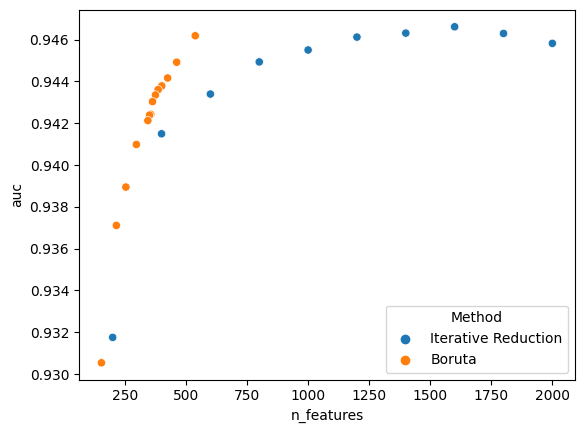

In [25]:
sns.scatterplot(data=perf,x='n_features',y=metric,hue='Method')
plt.show()